Episode 1: Reward = 13.0
Episode 2: Reward = 12.0
Episode 3: Reward = 18.0
Episode 4: Reward = 20.0
Episode 5: Reward = 18.0
Episode 6: Reward = 17.0
Episode 7: Reward = 40.0
Episode 8: Reward = 18.0
Episode 9: Reward = 13.0
Episode 10: Reward = 22.0
Episode 11: Reward = 16.0
Episode 12: Reward = 13.0
Episode 13: Reward = 43.0
Episode 14: Reward = 18.0
Episode 15: Reward = 22.0
Episode 16: Reward = 31.0
Episode 17: Reward = 21.0
Episode 18: Reward = 44.0
Episode 19: Reward = 20.0
Episode 20: Reward = 21.0
Episode 21: Reward = 39.0
Episode 22: Reward = 13.0
Episode 23: Reward = 24.0
Episode 24: Reward = 12.0
Episode 25: Reward = 19.0
Episode 26: Reward = 25.0
Episode 27: Reward = 18.0
Episode 28: Reward = 13.0
Episode 29: Reward = 14.0
Episode 30: Reward = 11.0
Episode 31: Reward = 10.0
Episode 32: Reward = 19.0
Episode 33: Reward = 71.0
Episode 34: Reward = 24.0
Episode 35: Reward = 31.0
Episode 36: Reward = 16.0
Episode 37: Reward = 12.0
Episode 38: Reward = 18.0
Episode 39: Reward = 

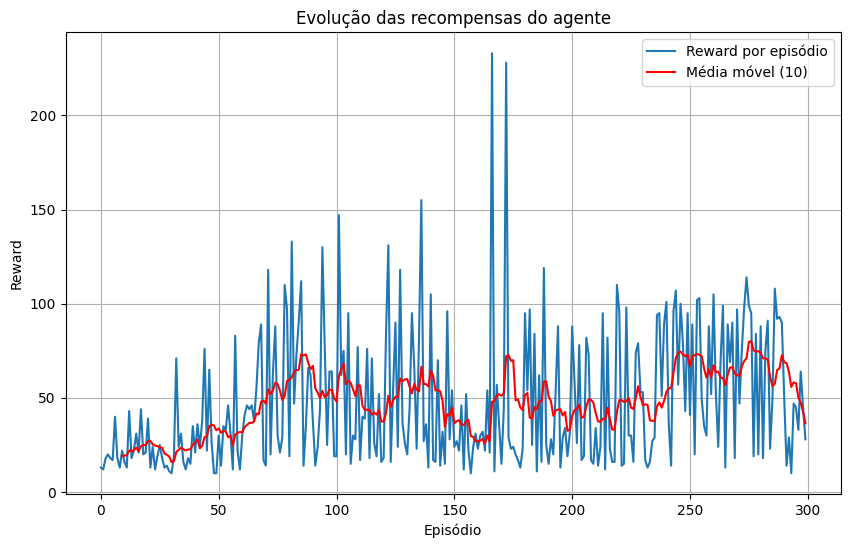

In [18]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# === Ambiente ===
env = gym.make("CartPole-v1")
num_actions = env.action_space.n
state_shape = env.observation_space.shape

# === Modelo Q-Network ===
def create_q_model():
    return keras.Sequential([
        keras.layers.InputLayer(state_shape),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(num_actions, activation="linear"),
    ])

model = create_q_model()
target_model = create_q_model()
target_model.set_weights(model.get_weights())

optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.Huber()

# === Replay buffer ===
action_history, state_history, state_next_history, rewards_history, done_history = [], [], [], [], []
batch_size = 32
gamma = 0.99
max_steps_per_episode = 500

# === Epsilon-greedy ===
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995  # decaimento por episódio

# === Treinamento ===
episodes = 300
running_rewards = []

for ep in range(episodes):
    state, _ = env.reset()
    episode_reward = 0

    for t in range(max_steps_per_episode):
        # Escolha de ação
        if np.random.rand() < epsilon:
            action = np.random.choice(num_actions)
        else:
            state_tensor = tf.expand_dims(tf.convert_to_tensor(state), 0)
            q_values = model(state_tensor, training=False)
            action = int(tf.argmax(q_values[0]).numpy())

        # Passo no ambiente
        next_state, reward, done, _, _ = env.step(action)
        episode_reward += reward

        # Armazena no buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(next_state)
        rewards_history.append(reward)
        done_history.append(done)
        state = next_state

        # Treino do modelo
        if len(done_history) > batch_size:
            indices = np.random.choice(len(done_history), size=batch_size)
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = np.array([rewards_history[i] for i in indices])
            action_sample = np.array([action_history[i] for i in indices])
            done_sample = np.array([float(done_history[i]) for i in indices])

            future_rewards = target_model.predict(state_next_sample, verbose=0)
            updated_q_values = rewards_sample + gamma * np.max(future_rewards, axis=1) * (1 - done_sample)

            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                q_values = model(state_sample)
                q_action = tf.reduce_sum(q_values * masks, axis=1)
                loss = loss_fn(updated_q_values, q_action)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if done:
            break

    # Atualiza target model a cada 10 episódios
    if ep % 10 == 0:
        target_model.set_weights(model.get_weights())

    # Decai epsilon
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    running_rewards.append(episode_reward)
    print(f"Episode {ep+1}: Reward = {episode_reward}")

# === Plot e salva gráfico ===
window = 10
smoothed_rewards = np.convolve(running_rewards, np.ones(window)/window, mode='valid')
plt.figure(figsize=(10,6))
plt.plot(running_rewards, label='Reward por episódio')
plt.plot(range(window-1, len(running_rewards)), smoothed_rewards, label=f'Média móvel ({window})', color='red')
plt.xlabel('Episódio')
plt.ylabel('Reward')
plt.title('Evolução das recompensas do agente')
plt.legend()
plt.grid(True)
plt.savefig('evolucao_rewards.png', dpi=300)
plt.show()

In [19]:
import imageio

env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

N_EPISODES = 3  # quantos episódios você quer gravar

for ep in range(N_EPISODES):
    state, _ = env.reset()
    done = False
    while not done:
        # Escolhe ação greedy
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, 0)
        q_values = model(state_tensor, training=False)
        action = int(tf.argmax(q_values[0]).numpy())

        # Avança no ambiente
        state, reward, done, _, _ = env.step(action)

        # Captura frame
        frame = env.render()
        frames.append(frame)

env.close()

# Salva tudo num único vídeo
imageio.mimsave("cartpole_dqn.mp4", frames, fps=30)
print("Vídeo salvo como cartpole_dqn.mp4")

Vídeo salvo como cartpole_dqn.mp4


In [20]:
from IPython.display import Video

# Caminho local ou URL
Video("/content/cartpole_dqn.mp4", embed=True, width=600, height=400)